This notebook reports some text analysis conducted on a selection of quotes, in English, extracted from the database of the EIGE lead project "A study of collected narratives on gender perceptions in the 27 EU Member States", openly available on the EIGE Gender Statistics Database (https://eige.europa.eu/gender-statistics/dgs).
The dataset comprises relevant quotes extracted from interviews conducted with participants together with some demographic and metadata collected by the dataset curators. The interviewers were asked to talk about events of their life in which they thought about gender differences. 

This is just a first experiment, refinement is needed in man 
If you need the processed dataset that I used, do not hesitate to contact me

In [1]:
import pandas as pd
import numpy as np
import re
from spellchecker import SpellChecker
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
#nltk.download('stopwords')

In [2]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [3]:
all_stopwords = stopwords.words('english')
all_stopwords.append('the')
all_stopwords.append('e')
all_stopwords.append('in')

In [4]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ilaria.bonavita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Loading data and first descriptive statistics

The data have been extracted from the original mx4 database and processed in R. The result of the preprocessing is a csv in which every row refers to a participant of the study (the unique identifier of the quote-participant is in "Document_name") and the columns contain different demographic and metadata related with the quote (Sex, marital status, employment status, etc.). The last column "text" is the main subject of analysis. It contains the chunks of interview, extracted from the original quote document, told by the participant. 

In [6]:
DATA_PATH = "./df_all.tsv"

In [7]:
df = pd.read_csv(DATA_PATH, sep='\t')

In [8]:
df.head()

,Document_group,Document_name,N_coded_segments,N_memos,Author,Country,Sex,Marital_status,Employment_status,Employment_status_of_partner,...,Sq1_Change,Sq2_Satisfaction,Sq3_Personal.control,Sq4_Strereotypes,Sq5_Outcome,Sq6_FairvsUnfair,Sq7_Gender,Key_actors_in_the_story,Age,text
0,AT_quotes,AT_Q_F_21_CFR,7,0,Barbara Helfferich,1,2,6,8,8,...,5,4,4,2,6,6,4,"mother,father,friends,media,schools, clubsia,s...",21,*| 1 | “I believe that my family was never rea...
1,AT_quotes,AT_Q_M_31_CFR,9,0,Barbara Helfferich,1,1,5,8,8,...,5,5,3,3,5,6,4,"mother,father,siblings,employer,friends,peers,...",31,*| 1 | (R): I only have insignificant stories ...
2,AT_quotes,AT_Q_M_47_ID,12,0,Barbara Helfferich,1,1,3,1,8,...,3,2,2,4,2,6,4,"mother,friends, peers,school",47,"*| 1 | “What I find interesting myself, what i..."
3,AT_quotes,AT_Q_F_35_ID,19,0,Barbara Helfferich,1,2,2,1,3,...,5,4,2,5,4,3,5,"father,mother,teacher,aunt,grandmother",35,"*| 1 | “Yes, I must say that I grew up in a ve..."
4,AT_quotes,AT_Q_F_21_VIO,10,0,Barbara Helfferich,1,2,6,8,8,...,4,2,2,5,3,3,4,"friends,peers,colleagues,media",21,"*| 1 | (R):“Yes, I do know a good story. I am..."


In [9]:
df.shape

(475, 25)

## Topics from the annotations

The last three chars of the "Document_name" indicate the topic of the quote. I here extract it and add in a separate column to analyse their distribution among male (Sex=1) and women participant (Sex=2).

In [10]:
df['topic'] = [i.split('_')[4] for i in df.Document_name]

df['topic'] = df['topic'].astype('category')

topictab = pd.crosstab(df.topic, df.Sex)

topictab

Sex,1,2
topic,,
CFR2,0,1
LEI,1,0
PRO,1,0
20,1,0
CFR,49,39
CFR1,15,15
CFR2,15,16
CFR3,3,0
CRF,5,2


## Key actors in the story
The dataset provides also human-crafted annotation on the key actors of the story told by the participant. After cleaning and homogenizing the format of the annotations, I compute the frequencies of appearence of the different actors, divided by gender. The frequencies are reported (in percentages) in the barplot below.

/home/ilaria.bonavita/anaconda3/envs/gender/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(23, 2)
(27, 2)


Text(0.5, 1.0, 'Key actors in the story by gender')

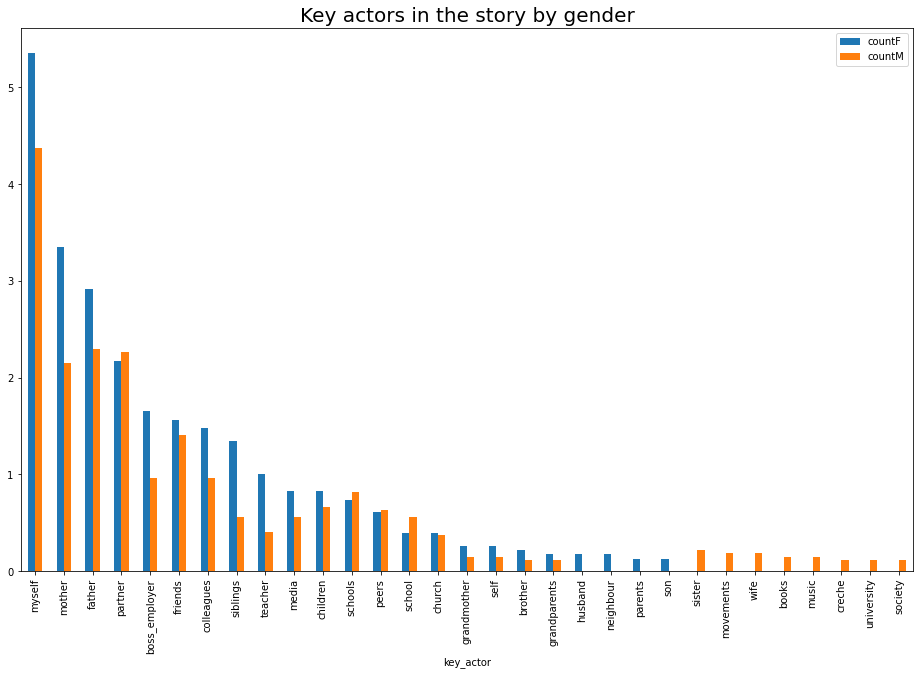

In [11]:
spell  = SpellChecker()


def spell_check(x):
    correct_word = []
    mispelled_word = x.split()
    for word in mispelled_word:
        correct_word.append(spell.correction(word))
    return ' '.join(correct_word)


def make_actors_list(al):
    
    al = re.split('[,;-]', al)
    al = [ i.replace(" ","") for i in al]
    #al = [ spell.correction(i.lower()) for i in al if i.isalpha() and len(i)>1]# and not i in ['or','in','the']]
    al = [ i for i in al if re.match("^[A-Za-z_-]*$", i) and len(i)>1]
    al = list(set(al))
    #al = [spell_check(i) for i in al]
    
    return al

df['Key_actors_in_the_story'] = [i.lower() for i in df['Key_actors_in_the_story']]
df['Key_actors_in_the_story'] = [ re.sub(r'\bme\b', 'myself', i)
                                 for i in df['Key_actors_in_the_story']]
df['Key_actors_in_the_story'] = [ re.sub(r'\bemployer\b', 'boss_employer', i)
                                 for i in df['Key_actors_in_the_story']]
df['Key_actors_in_the_story'] = [ re.sub(r'\bemployer_boss\b', 'boss_employer', i)
                                 for i in df['Key_actors_in_the_story']]
df['Key_actors_in_the_story'] = [ re.sub(r'\bboss\b', 'boss_employer', i)
                                 for i in df['Key_actors_in_the_story']]
df['key_actors_list'] = None


for i in range(len(df)):
    al = df.Key_actors_in_the_story.iloc[i]
    df.key_actors_list.iloc[i] = make_actors_list(al)

w_actors = []
for sublist in df.key_actors_list.loc[df.Sex==2]:
    for item in sublist:
        w_actors.append(item)
m_actors = []
for sublist in df.key_actors_list.loc[df.Sex==1]:
    for item in sublist:
        m_actors.append(item)

wc = Counter(w_actors).most_common()

mc = Counter(m_actors).most_common()

wdf = pd.DataFrame([i for i  in wc if i[1]>2], columns=['key_actor','countF'])
mdf = pd.DataFrame([i for i  in mc if i[1]>2], columns=['key_actor','countM'])
wdf.countF = wdf.countF/len(wdf)
mdf.countM = mdf.countM/len(mdf)

print(wdf.shape)
print(mdf.shape)

key_counts_df = pd.merge(left=wdf, right=mdf, how='outer', left_on='key_actor', right_on='key_actor')


key_counts_df = key_counts_df.set_index('key_actor')
ax = key_counts_df[["countF", "countM"]].plot(kind="bar", figsize=(16,10))
ax.set_title('Key actors in the story by gender', fontsize=20)  #




# Topic modelling with LDA
LDA (short for Latent Dirichlet Allocation) is an unsupervised machine-learning model that takes documents as input and finds topics as output. The model also says in what percentage each document talks about each topic.
I perform here some pre-processing and text cleaning necessary, before feeding the quotes to the LDA model.
The topics extracted are not of clear interpreatation and a high degree of overlap is present. The biggest topics seem to refer to family, parenthood and childcare. Other topics that can be identified are school, sport, work and physical characteristics.

In [12]:
# Convert to list
data = df.text.values.tolist()




def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])


[['believe', 'that', 'my', 'family', 'was', 'never', 'really', 'very', 'traditional', 'that', 'is', 'what', 'observed', 'about', 'my', 'dad', 'and', 'my', 'mom', 'true', 'my', 'grandmother', 'was', 'at', 'home', 'but', 'don', 'really', 'know', 'don', 'really', 'remember', 'those', 'days', 'can', 'only', 'remember', 'that', 'she', 'was', 'retired', 'and', 'that', 'my', 'two', 'aunts', 'were', 'at', 'home', 'for', 'long', 'time', 'before', 'they', 'started', 'working', 'again', 'in', 'my', 'immediate', 'family', 'it', 'was', 'not', 'like', 'that', 'my', 'dad', 'always', 'worked', 'and', 'my', 'mom', 'always', 'worked', 'after', 'they', 'separated', 'was', 'alone', 'lot', 'because', 'mom', 'had', 'to', 'work', 'lot', 'but', 'really', 'did', 'not', 'mind', 'that', 'much', 'that', 'came', 'home', 'alone', 'after', 'school', 'and', 'then', 'stayed', 'there', 'alone', 'until', 'or', 'in', 'the', 'afternoon', 'that', 'was', 'ok', 'it', 'was', 'never', 'that', 'typical', 'picture', 'that', 'is'

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(["man", "men", "woman", "women", "year", "fact","many",
                  "one","well","thing", "boy","girl","boys","girls","things",
                   "thing","female","male",
                  "think","really", "yes","hi", "people",
                   "of course","course","person","lot","something","way",
                   "person", "word", "words"])

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ'])

print(data_lemmatized[:1])

[['family', 'traditional', 'observed', 'dad', 'mom', 'true', 'grandmother', 'know', 'day', 'aunt', 'home', 'long', 'time', 'immediate', 'family', 'dad', 'mom', 'alone', 'mom', 'work', 'mind', 'alone', 'school', 'alone', 'afternoon', 'typical', 'picture', 'care', 'child', 'care', 'mega', 'help', 'notice', 'household', 'oftentime', 'time', 'clean', 'sacrifice', 'day', 'devaluing', 'home', 'decision', 'mother', 'much', 'work', 'job', 'admire', 'work', 'child', 'single', 'parent', 'difficult', 'friend', 'schoolmate', 'child', 'problem', 'job', 'old', 'child', 'small', 'predictable', 'miss', 'work', 'time', 'time', 'care', 'child', 'problem', 'employer', 'wrong']]


In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [18]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('admire', 1),
  ('afternoon', 1),
  ('alone', 3),
  ('aunt', 1),
  ('care', 3),
  ('child', 5),
  ('clean', 1),
  ('dad', 2),
  ('day', 2),
  ('decision', 1),
  ('devaluing', 1),
  ('difficult', 1),
  ('employer', 1),
  ('family', 2),
  ('friend', 1),
  ('grandmother', 1),
  ('help', 1),
  ('home', 2),
  ('household', 1),
  ('immediate', 1),
  ('job', 2),
  ('know', 1),
  ('long', 1),
  ('mega', 1),
  ('mind', 1),
  ('miss', 1),
  ('mom', 3),
  ('mother', 1),
  ('much', 1),
  ('notice', 1),
  ('observed', 1),
  ('oftentime', 1),
  ('old', 1),
  ('parent', 1),
  ('picture', 1),
  ('predictable', 1),
  ('problem', 2),
  ('sacrifice', 1),
  ('school', 1),
  ('schoolmate', 1),
  ('single', 1),
  ('small', 1),
  ('time', 4),
  ('traditional', 1),
  ('true', 1),
  ('typical', 1),
  ('work', 4),
  ('wrong', 1)]]

In [19]:
# Build LDA model
num_topics = 12
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=10,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha= 'auto', 
                                           decay=0.5,
                                           per_word_topics=True)

In [20]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.022*"skirt" + 0.019*"complicated" + 0.012*"uncle" + 0.012*"seat" + 0.008*"ask" + 0.007*"choose" + 0.006*"studied" + 0.005*"remote" + 0.005*"chock" + 0.005*"predominant"'), (1, '0.041*"town" + 0.028*"laughter" + 0.023*"math" + 0.014*"drive" + 0.014*"claim" + 0.013*"theme" + 0.013*"gay" + 0.012*"driver" + 0.011*"group" + 0.010*"handicraft"'), (2, '0.025*"french" + 0.025*"high_school" + 0.021*"inferior" + 0.012*"read" + 0.011*"event" + 0.009*"few" + 0.008*"see" + 0.008*"standard" + 0.007*"enemy" + 0.005*"clerk"'), (3, '0.016*"situation" + 0.014*"year" + 0.014*"position" + 0.014*"profession" + 0.013*"company" + 0.012*"team" + 0.011*"colleague" + 0.010*"field" + 0.010*"doctor" + 0.010*"problem"'), (4, '0.018*"friend" + 0.015*"sport" + 0.014*"good" + 0.014*"kind" + 0.013*"example" + 0.013*"different" + 0.012*"society" + 0.011*"right" + 0.010*"party" + 0.010*"guy"'), (5, '0.046*"child" + 0.033*"time" + 0.027*"mother" + 0.027*"family" + 0.016*"father" + 0.014*"home" + 0.012*"parent" + 

In [21]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.105357004350111

Coherence Score:  0.4339267357107968


In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/ilaria.bonavita/anaconda3/envs/gender/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.300028  0.025808       1        1  41.343586
10    -0.289481  0.000038       2        1  25.875864
3     -0.148079  0.101749       3        1  11.764767
4     -0.194283  0.003111       4        1  11.757792
11     0.008334 -0.326888       5        1   4.952622
8      0.138195  0.056355       6        1   1.473377
1      0.129278  0.018652       7        1   1.094741
9      0.138011  0.026675       8        1   0.519394
7      0.135886  0.026922       9        1   0.430662
6      0.127009  0.022192      10        1   0.282863
2      0.128540  0.023591      11        1   0.277089
0      0.126616  0.021794      12        1   0.227241, topic_info=    Category        Freq          Term       Total  loglift  logprob
38   Default  266.000000        school  266.000000  30.0000  30.0000
5    Default  904.000000         child  904.000000  29.0000  29.0000
186  Default  143.000000       teacher  143.000000  28.0000  28.0000
447  Default  167.000000         study  167.000000  27.0000  27.0000
46   Default  679.000000          work  679.000000  26.0000  26.0000
..       ...         ...           ...         ...      ...      ...
148  Topic12    0.318223       counter    4.820457   3.3690  -5.7513
3    Topic12    0.385087          aunt   10.861391   2.7474  -5.5605
185  Topic12    0.268817         table   17.552433   1.9080  -5.9200
170  Topic12    0.114022       primary    4.028871   2.5221  -6.7776
137  Topic12    0.110716  agricultural    1.181206   3.7196  -6.8070

[585 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
426       1  0.045547     ability
426       3  0.865398     ability
426       4  0.091095     ability
467       6  0.894596      absent
650       7  0.900480  acceptable
...     ...       ...         ...
191       4  0.006587        year
401       1  0.663094       young
401       2  0.084202       young
401       3  0.047364       young
401       4  0.205243       young

[737 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 11, 4, 5, 12, 9, 2, 10, 8, 7, 3, 1])

# Sentiment Analysis
I analyse here the polarity of the quotes (-1 very negative, 1 very positive sentiment). The first histogram gives an idea of the overall polarity distribution. In the second histogram the polarity distribution is divided by gender. Finally, the boxplot present the distribution of the "most positive" and "most negative" sentences in each quote, divided by gender. Overall, it seems that women text has a slighly more positive sentiment. In general, the sentiment of the texts seems to be neutral: we can observe that the majority of the quotes have a sentiment between 0 and 0.2.

In [23]:
df['text'] = df.text.astype(str)
df['polarity'] = df.text.apply(lambda x: TextBlob(x).sentiment[0])
df['subjectivity'] = df.text.apply(lambda x: TextBlob(x).sentiment[1])

In [24]:
from plotly.offline import init_notebook_mode, iplot

from plotly.graph_objs import FigureWidget
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

df['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')


In [25]:
import plotly.graph_objs as go

x1 = df.loc[df.Sex==1, 'polarity']
x0 = df.loc[df.Sex == 2, 'polarity']

trace1 = go.Histogram(
    x=x0, name='Men', 
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Women',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Distribution of Sentiment polarity by gender')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='overlaid histogram')


In [ ]:
# Refined polarity - get for every period the most positive and the most negative. Do men and women are equally extreeme?

In [26]:
df['max_polarity'] = None
df['min_polarity'] = None
df['most_pos_sentence'] = None
df['most_neg_sentence'] = None
for i, t in enumerate(df.text):
    t = TextBlob(t)
    tlist = [s.sentiment.polarity for s in t.sentences ]
    df['max_polarity'].iloc[i] = max(tlist)
    df['min_polarity'].iloc[i] = min(tlist)
    df['most_pos_sentence'].iloc[i] = t.sentences[tlist.index(max(tlist))]
    df['most_neg_sentence'].iloc[i] = t.sentences[tlist.index(min(tlist))]

In [27]:
df.columns = df.columns.astype(str)

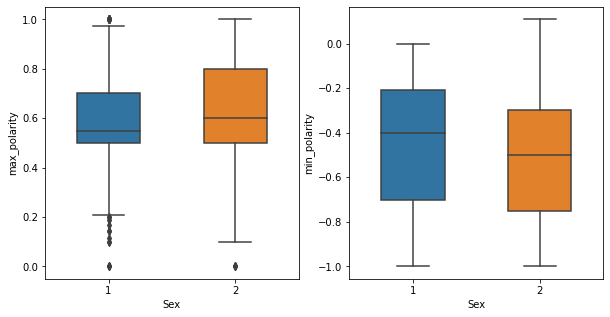

In [28]:
import seaborn as sns

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)

sdf = df[['max_polarity','min_polarity','Sex']]

ax = sns.boxplot(y='max_polarity', x='Sex', 
                 data=sdf, 
                 width=0.5)

plt.subplot(1, 2, 2)
ax = sns.boxplot(y='min_polarity', x='Sex', 
                 data=sdf, 
                 width=0.5)
plt.show()

# Word Clouds
Using nltk tokenization and tagging, I remove from the text articles, stop words, preposition and keep ajectives and nouns only. I also remove the most common and less meaninful words. Afterwords, I plot a word clouds, divided by gender to have a picture of the differences among the most common used words by male and women.

In [29]:
textm = " ".join(text for text in df.text.loc[df.Sex==1]).lower()
print ("There are {} words in the combination of all texts".format(len(textm)))


There are 701132 words in the combination of all texts


In [38]:
toremovem = list()
tokens = nltk.word_tokenize(textm)
tagged = nltk.pos_tag(tokens)
for to, ta in tagged:
    if(ta not in ['FW', 'JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS']):
        toremovem.append(to)

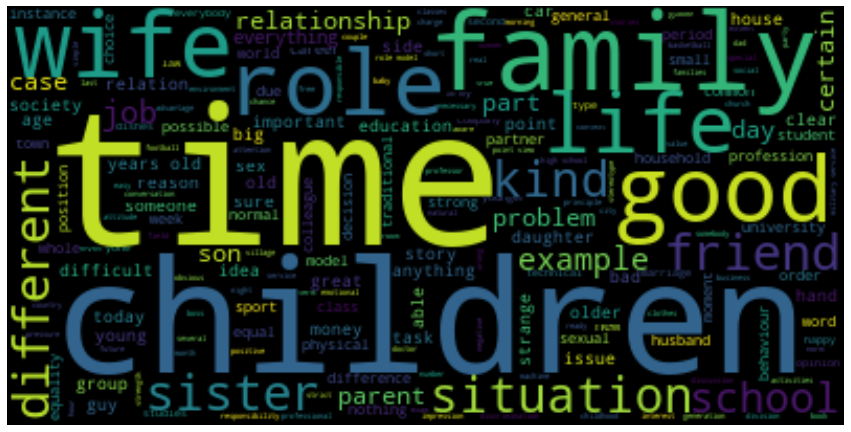

In [39]:
# Generate a word cloud image
stopwords = set(STOPWORDS)
stopwords.update(["man", "men", "woman", "women", "year", "fact","many",
                  "one","well","thing", "boy","girl","boys","girls",
                  "think","really", "yes","hi", "people","of course","course","person","lot","something","way"] + toremovem)


# Getting rid of the stopwords
clean_text = [word for word in textm.split() if word not in stopwords]

# Converting the list to string
text = ' '.join([str(elem) for elem in clean_text])

wordcloud = WordCloud(stopwords=stopwords).generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [40]:
textf = " ".join(text for text in df.text.loc[df.Sex==2]).lower()
print ("There are {} words in the combination of all texts".format(len(textf)))


There are 758812 words in the combination of all texts


In [41]:
toremovef = list()
tokens = nltk.word_tokenize(textf)
tagged = nltk.pos_tag(tokens)
for to, ta in tagged:
    if(ta not in ['FW', 'JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS']):
        toremovef.append(to)

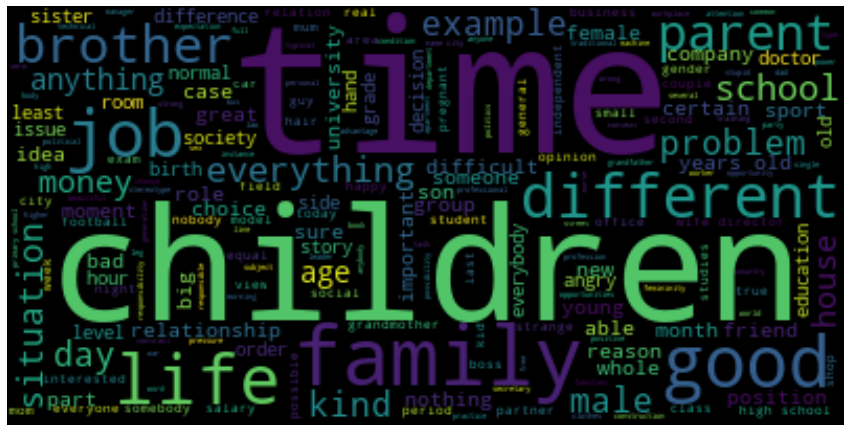

In [42]:
# Generate a word cloud image
stopwords = set(STOPWORDS)
stopwords.update(["man", "men", "woman", "women","fact","year","many",
                  "one","well","thing", "boy","girl","boys","girls",
                  "think","really", "yes","hi", "people","of course","course",
                  "person","lot","something","way"] + toremovef)

# Getting rid of the stopwords
clean_text = [word for word in textf.split() if word not in stopwords]

# Converting the list to string
text = ' '.join([str(elem) for elem in clean_text])

wordcloud = WordCloud(stopwords=stopwords).generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Entity analysis
Spicy and nltk provide different functions for extracting entities from a text. Laveraging on these, several text analysis can be done. Here I explore the following: given a noun of interest (e.g. "man", "woman"), retrieve from the text the adjactives used in relation to it.

In [33]:
# take smaller dataset
df_small = pd.read_csv("./df2.tsv", sep =',')

all_text = [' '.join(df_small['text'])]

doc = nlp(all_text[0])

In [34]:
# how many entities are found?
print(len(doc.ents))

1436


In [35]:
# how are the entities distributed?
labels = [x.label_ for x in doc.ents]
Counter(labels)

Counter({'DATE': 426,
         'CARDINAL': 354,
         'TIME': 81,
         'PRODUCT': 99,
         'GPE': 86,
         'NORP': 71,
         'PERSON': 41,
         'ORDINAL': 130,
         'ORG': 76,
         'MONEY': 4,
         'WORK_OF_ART': 14,
         'QUANTITY': 11,
         'LOC': 15,
         'EVENT': 6,
         'LANGUAGE': 9,
         'LAW': 1,
         'PERCENT': 8,
         'FAC': 4})

In [36]:
# which are the entity PERSON?
[x for x in doc.ents if x.label_ == "PERSON"]

[Dad,
 Y.,
 Miss B.,
 J.,
 L.,
 mouth agape,
 Ms H,
 C.,
 Justin Bieber,
 Scouts,
 Km,
 Bulimia,
 Anorexia,
 Bulimia,
 St. Nicolas,
 St. Nicolas,
 Santa Claus,
 cook,
 Joop Ter Uil,
 Joop ter Uil,
 a Joop Ter,
 Joop Ter Uil,
 Joop Ter Uil,
 Joop Ter Uil,
 Mum,
 Mum,
 Dad,
 Mum,
 Mum,
 hairdresser,
 judo,
 judo,
 Judo,
 Err,
 I.,
 bin,
 Qwan,
 Dad,
 Sciences Po,
 Jesus,
 Adam]

In [37]:
# how many sentences in the text?
sentences = [x for x in doc.sents]
print(len(sentences))

5632


In [38]:
def get_noun_adj_pairs(sentences, target_names):
    noun_adj_pairs = []
    for s in sentences:
        if any(str(s).lower().find(check)>-1  for check in target_names):
            doc = nlp(str(s))
            for i,token in enumerate(doc):
                if (token.pos_ not in ('NOUN','PROPN')):
                    continue
                if (str(token) not in target_names):
                    continue
                for j in range(i+1,len(doc)):
                    if doc[j].dep_ == 'acomp':
                        adj = str(doc[j]).replace(" ","")
                        noun_adj_pairs.append((token,adj))
                        break
    return noun_adj_pairs

In [39]:
# Which are the adjectives associated with woman?

target_names = ["woman", "women","girl","girls"]
na_pairs = get_noun_adj_pairs(sentences, target_names)
Counter([i[1] for i in na_pairs]).most_common()

[('good', 5),
 ('difficult', 4),
 ('able', 4),
 ('right', 4),
 ('nice', 3),
 ('cool', 3),
 ('more', 3),
 ('equal', 3),
 ('honest', 3),
 ('married', 2),
 ('present', 2),
 ('prepared', 2),
 ('single', 2),
 ('aware', 2),
 ('shorter', 2),
 ('empathetic', 2),
 ('normal', 2),
 ('important', 2),
 ('young', 2),
 ('ok', 2),
 ('pregnant', 2),
 ('clear', 2),
 ('easier', 2),
 ('comfortable', 2),
 ('rooted', 2),
 ('opposed', 1),
 ('weaker', 1),
 ('reflecting', 1),
 ('natural', 1),
 ('great', 1),
 ('ambitious', 1),
 ('lucky', 1),
 ('superior', 1),
 ('brutal', 1),
 ('capable', 1),
 ('unfair', 1),
 ('careful', 1),
 ('fragile', 1),
 ('similar', 1),
 ('hard', 1),
 ('working', 1),
 ('demanding', 1),
 ('focused', 1),
 ('religious', 1),
 ('dean', 1),
 ('wound', 1),
 ('successful', 1),
 ('spoilt', 1),
 ('appreciated', 1),
 ('rebellious', 1),
 ('different', 1),
 ('higher', 1),
 ('stable', 1),
 ('likely', 1),
 ('reluctant', 1),
 ('feminine', 1),
 ('true', 1),
 ('dutiful', 1),
 ('determined', 1),
 ('essential'

In [40]:
# Which are the adjectives associated with men?

na_pairs = get_noun_adj_pairs(sentences, ['man','men','boy','boys','guy','guys'])
Counter([i[1] for i in na_pairs]).most_common()

[('able', 4),
 ('easier', 3),
 ('good', 3),
 ('interesting', 3),
 ('important', 3),
 ('rooted', 3),
 ('due', 2),
 ('interested', 2),
 ('more', 2),
 ('secluded', 2),
 ('equal', 2),
 ('pregnant', 2),
 ('stable', 2),
 ('careful', 2),
 ('afraid', 2),
 ('older', 2),
 ('different', 2),
 ('attractive', 2),
 ('confident', 2),
 ('present', 2),
 ('free', 2),
 ('honest', 2),
 ('weaker', 1),
 ('assured', 1),
 ('aware', 1),
 ('professional', 1),
 ('talked', 1),
 ('mad', 1),
 ('brutal', 1),
 ('empathetic', 1),
 ('reliable', 1),
 ('paternalistic', 1),
 ('naughty', 1),
 ('jealous', 1),
 ('related', 1),
 ('severe', 1),
 ('conflictive', 1),
 ('possible', 1),
 ('focused', 1),
 ('guilty', 1),
 ('negative', 1),
 ('unfortunate', 1),
 ('spoilt', 1),
 ('small', 1),
 ('right', 1),
 ('happy', 1),
 ('desperate', 1),
 ('forthcoming', 1),
 ('work', 1),
 ('great', 1),
 ('lower', 1),
 ('bad', 1),
 ('venturesome', 1),
 ('clear', 1),
 ('scared', 1),
 ('better', 1),
 ('clever', 1),
 ('sleepy', 1),
 ('sensitive', 1),
 (